In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.set_default_device("cpu")

In [2]:
from collections import namedtuple
def solve_and_test(X,y,beta,pi1,pi2,z,d):
  beta_hat = y @ torch.linalg.pinv(X)

  return (beta_hat - beta).square().sum()*(pi1/d) + ((beta_hat - beta) @ z).square().sum()*(pi2), (y - beta_hat @ X).square().mean()

def theory(pi1,c):
  if c < pi1:
    return pi1*c/(pi1-c)
  else:
    return (pi1**2)/(c-pi1) + pi1*(1-pi1/c) * beta.square().sum() / d - pi1*(1-pi1/c) * (beta.T @ z)**2/(z.square().sum() * d)

def create_data(d,n,k,z):
  X = torch.zeros(d,n)
  X[:,:n-k] = torch.randn(d, n-k)/np.sqrt(d)
  for i in range(k):
    X[:,n-k+i] = torch.randn(1)*z.flatten() #+ torch.randn_like(z)*0.0001
  return X

def create_y(X,beta):
  y = beta.T @ X
  return y + torch.randn_like(y)

def compute_curve(d,z,beta,Ns,T,pi1,pi2):
  N = len(Ns)
  losses = torch.zeros(N)
  train_error = torch.zeros(N)
  theory_errors = torch.zeros(N)
  for i in tqdm(range(N)):
    n = Ns[i]
    k = int(np.round(n*pi2))
    theory_errors[i] = theory(pi1,d/(n+0.5))
    for j in range(T):
      X = create_data(d,n,k,z)
      y = create_y(X,beta)
      risk, train = solve_and_test(X,y,beta.T,pi1,pi2,z,d)
      losses[i] += risk/T
      train_error[i] += train/T
  return losses, train_error, theory_errors

def compute_theory_curve(d,min_N, max_N, pi1):
  errors = torch.zeros(max_N - min_N)
  Ns_theory = torch.zeros(max_N - min_N)
  N = max_N - min_N
  for i in range(N):
    n = min_N+i+0.5
    k = int(np.round(n*pi1))
    errors[i] = theory(pi1,d/n)
    Ns_theory[i] = min_N+i+0.5
  return errors, Ns_theory

In [27]:
d = 600
z = torch.randn(d,1)/np.sqrt(d)
beta = torch.randn(d,1) #z*d
beta = beta - z.T @ beta * z

Ns = [2*250,2*275,2*325,2*350,2*400,2*450,2*500,2*550,2*600,2*650,2*700, 2*750, 2*800, 2*900, 2*1000]
T = 50

In [29]:
pi1 = 0.8
pi2 = 1 - pi1

In [30]:
loss, train, t_loss = compute_curve(d,z,beta,Ns,T,pi1,pi2)

100%|██████████| 15/15 [02:42<00:00, 10.84s/it]


In [31]:
(loss-t_loss).abs()/(loss)

tensor([0.0123, 0.0051, 0.0006, 0.1143, 0.0348, 0.0037, 0.0143, 0.0191, 0.0012,
        0.0242, 0.0081, 0.0013, 0.0023, 0.0116, 0.0022])

In [32]:
errors, Ns_theory = compute_theory_curve(d,500,Ns[-1],pi1)

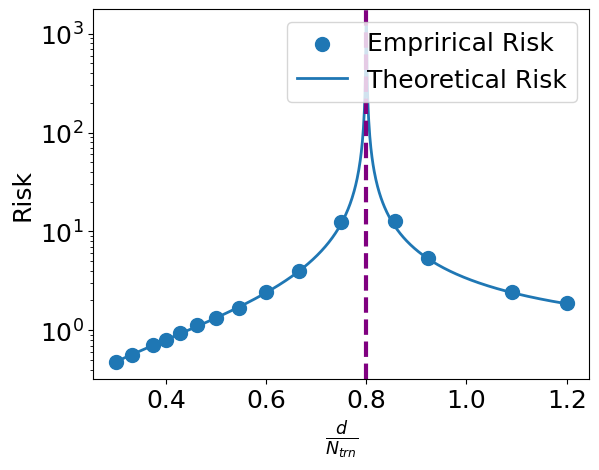

In [33]:
plt.scatter(d/(torch.tensor(Ns).cpu()),loss.cpu(), s = 100, label = "Emprirical Risk")
plt.yscale("log")
plt.plot(d/Ns_theory.cpu(), errors.cpu(), linewidth = 2, label = "Theoretical Risk")
plt.legend(fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.axvline(x=pi1, color='purple', linewidth = 3, linestyle='--', label = r"$\pi_1$")
plt.xlabel(r"$\frac{d}{N_{trn}}$", fontsize = 18)
plt.ylabel(r"Risk", fontsize = 18)
plt.savefig("Output-noise-perp-beta-z.pdf", bbox_inches='tight', facecolor='white', dpi = 100, format = 'pdf')